# **AI/ML - HDB Resale Price predictions**

By Jackson Chai

# 1. Importing relevant libraries and checking version

In [1]:
# Importing relevant libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-05-14 07:33:04.758598: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 07:33:04.783112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Checking Python Version

import sys

# Print the Python version
print("Current Python version:", sys.version)


Current Python version: 3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]


## 2. Data Analysis

### 2.1 Data Sources

2.1.1 Past HDB Resale Transactions (from January 2017 to April 2024)

> Core data from HDB with key information of each unit sold, such as: year and month sold, town, flat type, address, price, and lease details

> Data format provided from HDB website is an Excel CSV

In [3]:
# Uploading CSV into a pandas dataframe
# r'C:\Users\sg98c\OneDrive\Desktop\AI ML\Projects\Project 3 - HDB Resale prices\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv'

df_hdb = pd.read_csv(r'Projects/Project 3 - HDB Resale prices/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

### 2.2 Data Understanding

In [4]:
# Checking the first 5 lines in the dataframe

df_hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [5]:
# Checking the dimensions of the dataframe

df_hdb.shape

(177093, 11)

In [6]:
df_hdb.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,177093.000000,177093.000000,1.770930e+05
mean,97.201840,1995.978113,4.954835e+05
std,24.021424,14.009371,1.716296e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.700000e+05
50%,93.000000,1996.000000,4.650000e+05
75%,112.000000,2010.000000,5.900000e+05
max,249.000000,2022.000000,1.568888e+06


### 2.3 Data Cleaning

In [7]:
# Checking data types of the columns and missing values

df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177093 entries, 0 to 177092
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                177093 non-null  object 
 1   town                 177093 non-null  object 
 2   flat_type            177093 non-null  object 
 3   block                177093 non-null  object 
 4   street_name          177093 non-null  object 
 5   storey_range         177093 non-null  object 
 6   floor_area_sqm       177093 non-null  float64
 7   flat_model           177093 non-null  object 
 8   lease_commence_date  177093 non-null  int64  
 9   remaining_lease      177093 non-null  object 
 10  resale_price         177093 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.9+ MB


In [8]:
# Check for missing values in the dataset

print(df_hdb.isnull().sum())

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


> As there are no missing values in the dataset, no further data cleaning is required

### 2.4 Feature Engineering

In [9]:
# Converting 'month' to datetime format

df_hdb['month'] = pd.to_datetime(df_hdb['month'], format = '%Y-%m')

# Convert 'month' column into a numerical feature by extracting the year and the month number
df_hdb['year'] = df_hdb['month'].dt.year
df_hdb['month_num'] = df_hdb['month'].dt.month

print(df_hdb.head())


       month        town flat_type block        street_name storey_range  \
0 2017-01-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1 2017-01-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2 2017-01-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3 2017-01-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4 2017-01-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  year  month_num  
0      232000.0  2017          1  
1   

In [10]:
# Convert 'lease_commence_date' to datetime format (assuming January 1 of that year)

df_hdb['lease_commence_date'] = pd.to_datetime(df_hdb['lease_commence_date'], format='%Y')

# Convert 'lease_commence_date' column into a numerical feature by extracting the year
df_hdb['lease_commence_year'] = df_hdb['lease_commence_date'].dt.year

print(df_hdb.head())


       month        town flat_type block        street_name storey_range  \
0 2017-01-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1 2017-01-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2 2017-01-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3 2017-01-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4 2017-01-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model lease_commence_date     remaining_lease  \
0            44.0        Improved          1979-01-01  61 years 04 months   
1            67.0  New Generation          1978-01-01  60 years 07 months   
2            67.0  New Generation          1980-01-01  62 years 05 months   
3            68.0  New Generation          1980-01-01   62 years 01 month   
4            67.0  New Generation          1980-01-01  62 years 05 months   

   resale_price  year  month_num  lease_commence_year  
0      232000.0  2017   

In [11]:
 # Step-by-step transformation to handle 'remaining_lease'

# 1. Extract years and multiply by 12 to convert years to months
df_hdb['remaining_lease_months'] = df_hdb['remaining_lease'].str.extract(r'(\d+) years').astype(int) * 12

# 2. Extract months, handle missing months by filling NaNs with 0, then convert to integer
extracted_months = df_hdb['remaining_lease'].str.extract(r'(\d+) month').fillna(0).astype(int)

# Ensure 'extracted_months' is a DataFrame and not a Series; we expect it to be a DataFrame
if isinstance(extracted_months, pd.DataFrame):
    extracted_months = extracted_months[0]

# 3. Add the months to the total months calculated from years
df_hdb['remaining_lease_months'] += extracted_months

# Print the updated DataFrame to verify the results
print(df_hdb['remaining_lease_months'].head())
print(df_hdb.isnull().sum())

0    736
1    727
2    749
3    745
4    749
Name: remaining_lease_months, dtype: int64
month                     0
town                      0
flat_type                 0
block                     0
street_name               0
storey_range              0
floor_area_sqm            0
flat_model                0
lease_commence_date       0
remaining_lease           0
resale_price              0
year                      0
month_num                 0
lease_commence_year       0
remaining_lease_months    0
dtype: int64


> The 'remaining lease' column is in years-months format. However, converting this column to datetime is not helpful as that would just be extracting a date. Whereas, the remaining lease would be more useful if it is converted to time remaining (e.g. total months remaining).

In [12]:
# Dropping columns that are no longer needed

df_hdb.drop(['remaining_lease'], axis=1, inplace=True)

df_hdb.drop(['month'], axis=1, inplace=True)

df_hdb.drop(['lease_commence_date'], axis=1, inplace=True)



### 2.5 Identifying categorical and numerical columns

In [13]:
# Exclude the target variable and other non-feature columns to list features
non_feature_columns = ['resale_price']
feature_columns = [col for col in df_hdb.columns if col not in non_feature_columns]


In [14]:
# Identify categorical and numerical columns
categorical_cols = df_hdb[feature_columns].select_dtypes(include=['object', 'datetime']).columns.tolist()
numerical_cols = df_hdb[feature_columns].select_dtypes(include=['int64', 'float64', 'number']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']
Numerical columns: ['floor_area_sqm', 'year', 'month_num', 'lease_commence_year', 'remaining_lease_months']


### 2.6 Data visualisation

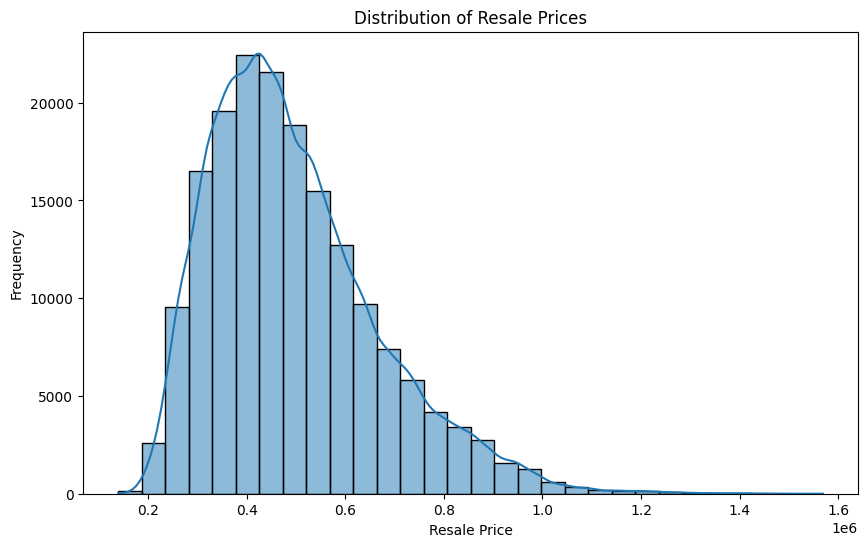

In [15]:
# Plot the distribution of the target variable (resale_price)
plt.figure(figsize=(10, 6))
sns.histplot(df_hdb['resale_price'], bins=30, kde=True)
plt.title('Distribution of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
plt.show()

Correlation Matrix:
                         floor_area_sqm      year  month_num  \
floor_area_sqm                1.000000 -0.032439   0.003675   
year                         -0.032439  1.000000  -0.137447   
month_num                     0.003675 -0.137447   1.000000   
lease_commence_year           0.116406  0.132426   0.002414   
remaining_lease_months        0.123392 -0.011317   0.002449   
resale_price                  0.601127  0.304527  -0.010267   

                        lease_commence_year  remaining_lease_months  \
floor_area_sqm                     0.116406                0.123392   
year                               0.132426               -0.011317   
month_num                          0.002414                0.002449   
lease_commence_year                1.000000                0.989219   
remaining_lease_months             0.989219                1.000000   
resale_price                       0.365519                0.324130   

                        resale_price  


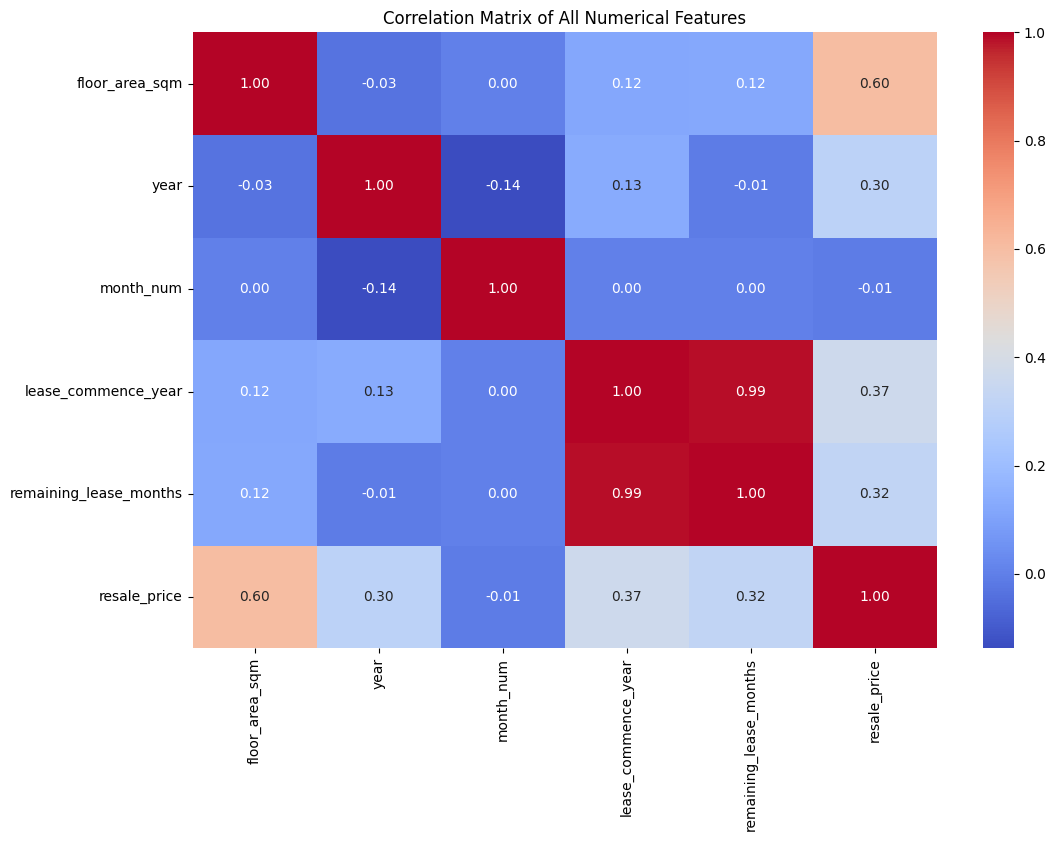

In [16]:
# Calculate correlation matrix
correlation_matrix = df_hdb[numerical_cols + non_feature_columns].corr()

# Display correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of All Numerical Features')
plt.show()

> Out of all numerical features, 'floor_area_sqm' has the highest correlation to the resale price, with a correlation of 0.60

### 2.7 Preparing data for modelling

In [17]:
features = numerical_cols + categorical_cols

X = df_hdb[features]
y = df_hdb['resale_price']

## 3. ML Model 1: Gradient Boosting Regressor

### 3.1 Preprocessing Pipeline

In [18]:
# Create a column transformer with OneHotEncoder for categorical data and StandardScaler for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


### 3.2 Splitting data into training and testing sets

In [19]:
# Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.3 Create and train the machine learning model 

In [20]:
# Initialize a pipeline with the preprocessor and a Gradient Boosting Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=500, learning_rate=0.3, max_depth=3, random_state=42))
])


In [21]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm', 'year',
                                                   'month_num',
                                                   'lease_commence_year',
                                                   'remaining_lease_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['town', 'flat_type', 'block',
                                                   'street_name',
                                                   'storey_range',
                                                   'flat_model'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.3, n_estimators=500,
                                           random_state=42))])

### 3.4 Make predictions

In [22]:
y_pred = model.predict(X_test)

### 3.5 Testing with a random row from X

In [23]:
# Display the features and target value for the 5th row
display(X.iloc[5])
print('The actual price for the 5th row is:', f'${y.iloc[5]:,.2f}')

# Select the test data for the 5th row, ensuring it remains a DataFrame
testdata = X.iloc[[5]]

# Make a prediction using the model
predicted_price = model.predict(testdata)

# Print the predicted price for the 5th row
print('The predicted price for the 5th row is:', f'${predicted_price[0]:,.2f}')


floor_area_sqm                        68.0
year                                  2017
month_num                                1
lease_commence_year                   1981
remaining_lease_months                 756
town                            ANG MO KIO
flat_type                           3 ROOM
block                                  150
street_name               ANG MO KIO AVE 5
storey_range                      01 TO 03
flat_model                  New Generation
Name: 5, dtype: object

The actual price for the 5th row is: $275,000.00
The predicted price for the 5th row is: $277,517.88


### 3.6. Calculating performance metrics

In [24]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 1107778023.568972
Root Mean Squared Error (RMSE): 33283.29946938813
Mean Absolute Error (MAE): 24831.42879807853
R^2 Score: 0.9620894017307179


### 3.7 Interpretation of my results

> Mean Squared Error (MSE): 1,107,778,023

Represents the average of the squares of errors, which is the average squared difference between the estimated values and the actual value. As the average difference will be squared, a high value suggests that the model may be making substantial errors on some prediction, therefore penalising models which produce more anomalies.

The value of approx 1.1 billion suggests that there are significant variations for some predictions (i.e. anomalies).


> Root Mean Squared Error (RMSE): 33,283

Square root of MSE. Indicates that on average, the model's predictions are about $33,283 away from the actual sale prices.

> Mean Absolute Error (MAE): 24,831

Average of the absolute errors (i.e. the average difference between the predicted values and actual values without considering the direction of the error (no squaring or square root)).

MAE of $24,831 indicates that on average, the model's predictions are about $24,831 away from the actual sale prices, ignoring direction of errors. 

> R² Score: 0.9620

The R² score, or coefficient of determination, indicates how well the regression predictions approximate the real data points. An R² of 0.9620 is relatively high, suggesting that the model explains about 96.21% of the variance observed in the resale prices with the given features.

### 3.8 Overall Interpretation

The high R² value contrasted with high MSE suggests that while the model explains a large proportion of the variance and is a good fit, the model may not be efficient in predicting anomalies / outliers.

### 3.9 Graph Interpretation

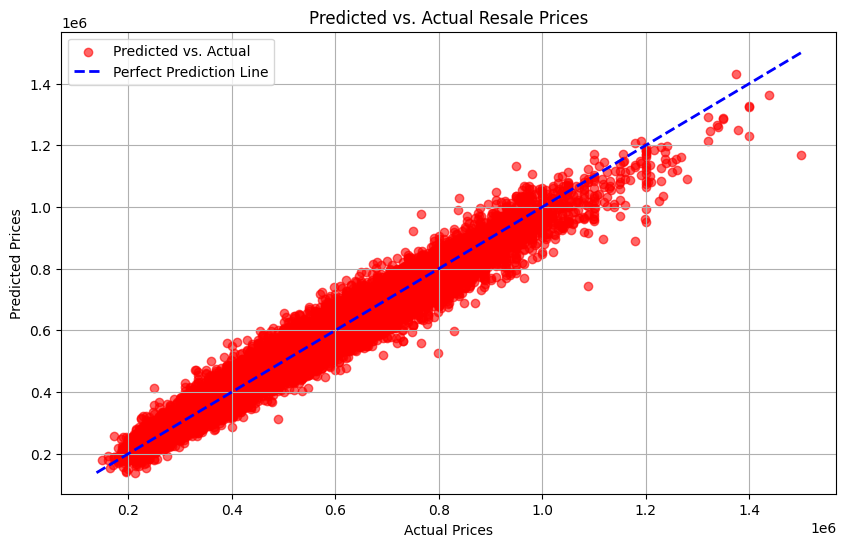

In [25]:
# Create a scatter plot comparing actual and predicted prices
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Plot actual vs. predicted prices
plt.scatter(y_test, y_pred, alpha=0.6, color='red', label='Predicted vs. Actual')

# Plot a line of perfect prediction
max_val = np.maximum(max(y_test), max(y_pred))  # Get the maximum of the y_test and y_pred
min_val = np.minimum(min(y_test), min(y_pred))  # Get the minimum of the y_test and y_pred
plt.plot([min_val, max_val], [min_val, max_val], 'blue', lw=2, linestyle='--', label='Perfect Prediction Line')

# Adding plot title and labels
plt.title('Predicted vs. Actual Resale Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)  # Adding a grid for easier reading of the plot

# Add a legend to the plot to identify the data
plt.legend()

# Show the plot
plt.show()

> Scatter Plot:

The x-coordinate represents the actual resale price (in S$million) of the home, and the y-coordinate represents the resale price (in S$million) predicted by the model for that same home.

> Line of Perfect Prediction:

Just a reference line that runs diagonally across the plot, where the predicted prices are equal to the actual prices. It's typically plotted from minimum to the maximum observed values on both axis. 

> How to interprete:

- The closer the scatter points are to the line, the more accurate the predictions are. This line acts as a benchmark for perfect predictions.

- The distance of points from this line visually indicates the error in the predictions. Points that lie far from this line represent large errors, while those close to the line represent small errors.

> My interpretation from graph generated:

- **Anomalies**: Across the graph, there are quite a few visible anomalies present in the scatterplot. This may suggest that the model is not adapted to accomodate for anomalies in prices. 

- **Overall Fit**: From prices S$0.1mil to S$1.0mil, the points in the scatterplot are relatively tight and fit around the line of perfect prediction, suggesting high accuracy of the predictions within this price range. However, from prices $1.0mil onwards, the points started to disperse and are further away from the line, suggesting that the model may not be able to predict prices accurately for this price range.

- **Error trends**: From prices S$0.1mil to S$1.0mil, the model does not seem to consistently overpredict or underpredict prices, and the errors seem equal. However, from prices $1.0mil onwards, the model seems to consistenly underpredict prices, where the points from this price range tend to be below the line of perfect prediction.

## 4. ML Model 2: Neural Network

### 4.1 Preprocessing Pipeline

In [26]:
# Create a column transformer with OneHotEncoder for categorical data and StandardScaler for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

### 4.2 Splitting data

In [27]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Preprocess the Data using the Preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [29]:
# Define the Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1))  # Output layer with one neuron for regression

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-14 07:34:12.413257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 07:34:12.416371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 07:34:12.416395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have bee

In [30]:
# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [31]:
# Step 7: Train the Model
nn_model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


I0000 00:00:1715672054.593364    4358 service.cc:145] XLA service 0x7f53c40060d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715672054.593399    4358 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-05-14 07:34:14.604537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 07:34:14.653694: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 169/3542 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - loss: 279108321280.0000 - mae: 497918.8438 

I0000 00:00:1715672055.057298    4358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3542/3542 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 198798016512.0000 - mae: 392262.5938 - val_loss: 11560085504.0000 - val_mae: 75715.6094
Epoch 2/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 9008893952.0000 - mae: 66762.7109 - val_loss: 4505708544.0000 - val_mae: 47786.4492
Epoch 3/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3991984640.0000 - mae: 45774.0938 - val_loss: 3236732672.0000 - val_mae: 41887.7266
Epoch 4/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3055316992.0000 - mae: 40767.6992 - val_loss: 2824530944.0000 - val_mae: 39684.7656
Epoch 5/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2685981184.0000 - mae: 38834.1719 - val_loss: 2661185024.0000 - val_mae: 38701.0195
Epoch 6/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2510082048.0000 - mae: 37694.0977 - val_loss: 2566956032.0000 - val_mae: 38226.1250
Epoch 7/50
3542/3542 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2434337280.0000 - mae: 37199.3789 - val_loss: 2512403456.0000 - val_m

In [32]:
# Predict on the testing set
y_pred_nn = nn_model.predict(X_test_preprocessed)


1107/1107 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step


In [33]:
# Calculate performance metrics
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network Performance:")
print("Mean Squared Error (MSE):", mse_nn)
print("Root Mean Squared Error (RMSE):", rmse_nn)
print("Mean Absolute Error (MAE):", mae_nn)
print("R^2 Score:", r2_nn)

Neural Network Performance:
Mean Squared Error (MSE): 959881138.9767814
Root Mean Squared Error (RMSE): 30981.948598769275
Mean Absolute Error (MAE): 22795.809523296113
R^2 Score: 0.967150758119599


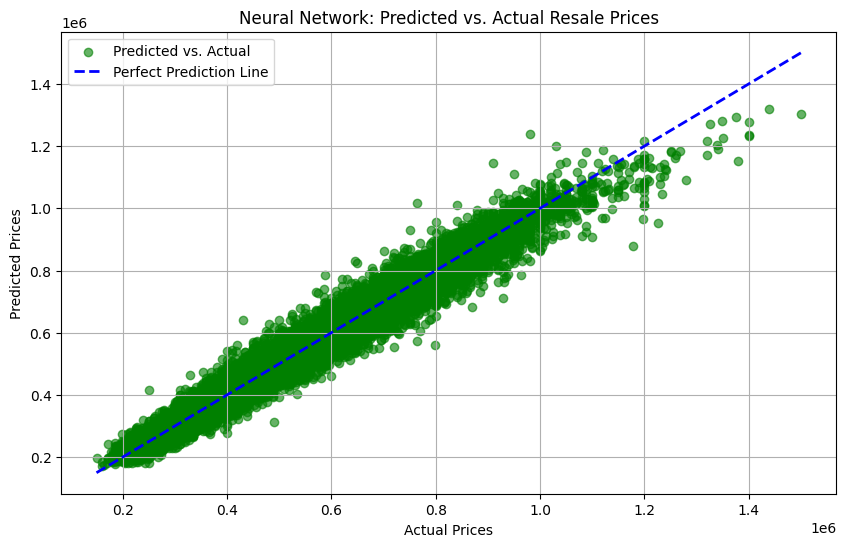

In [34]:
# Step 9: Visualize Model Predictions

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='green', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'blue', lw=2, linestyle='--', label='Perfect Prediction Line')
plt.title('Neural Network: Predicted vs. Actual Resale Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

## 5. ML Model 3: Random Forest Regressor

### 5.1 Preprocessing Pipeline

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

In [36]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Preprocess the Data using the Preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [38]:
# Define the Random Forest Regressor Model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [39]:
# Train the Model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm', 'year',
                                                   'month_num',
                                                   'lease_commence_year',
                                                   'remaining_lease_months']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['town', 'flat_type', 'block',
                                                   'street_name',
                                                   'storey_range',
                                                   'flat_model'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [40]:
# Predict on the testing set
y_pred_rf = rf_model.predict(X_test)

In [41]:
# Calculate performance metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance:")
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("Mean Absolute Error (MAE):", mae_rf)
print("R^2 Score:", r2_rf)

Random Forest Regressor Performance:
Mean Squared Error (MSE): 963561694.22948
Root Mean Squared Error (RMSE): 31041.29015085359
Mean Absolute Error (MAE): 21328.28476813438
R^2 Score: 0.9670248014309626


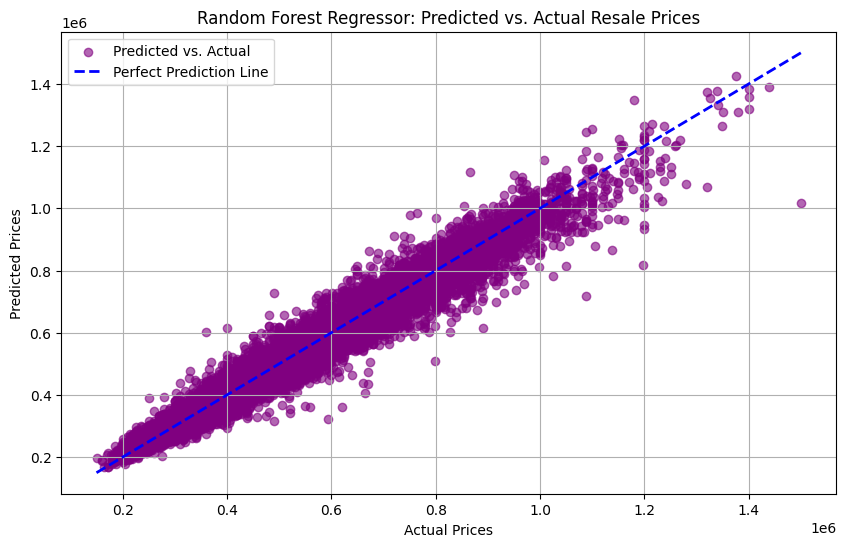

In [42]:
# Step 9: Visualize Model Predictions

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='purple', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'blue', lw=2, linestyle='--', label='Perfect Prediction Line')
plt.title('Random Forest Regressor: Predicted vs. Actual Resale Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()